## The smile detector

To add another rectangle depicting one's smile with the face detector, I will do this using the Haar cascade again because it already has a working model it trained on for detecting certain features of the face, while the MTCNN algorithm is only for the detection of a face. However, after adding the following lines of code about the smile classifier and smile detector, the program looked pretty weird during run-time.

Since the code wouldn't compile in Jupyter because of an "Out of memory" error, the program works in python IDLE, where I wrote and ran it and got the following result:

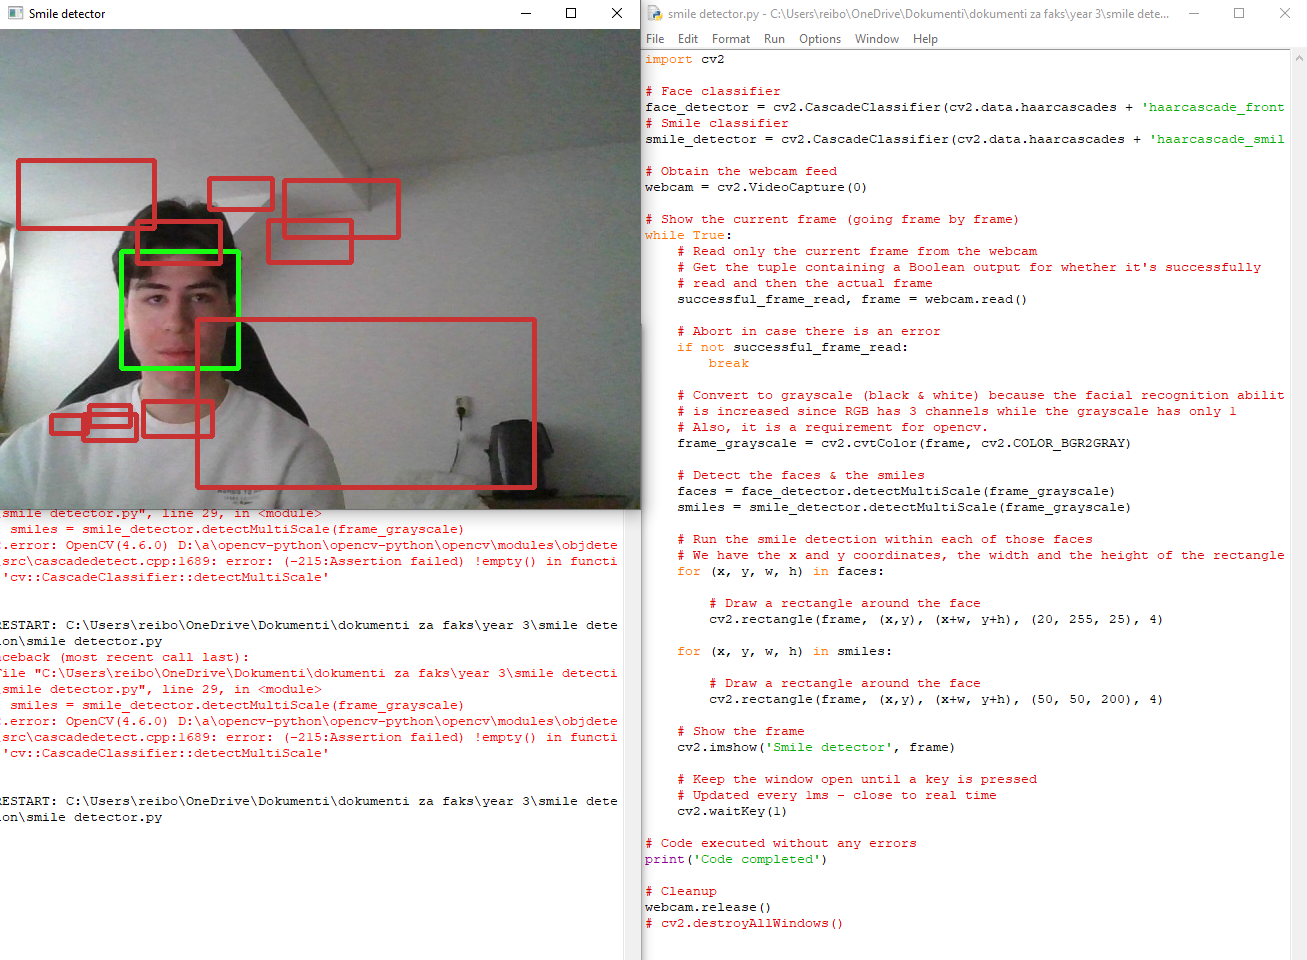


As you can already see, the red rectangles are supposedly smiles, however, I am pretty sure everyone can see they are obviously not. Now, the face classifier was trained for much more and there is a lot more data for faces than exclusively smiles, this is why the face detection works much better than the smiles for now. Another reason for this is that detecting a smile needs much less features and therefore will be more inaccurate than the face. Detecting a smile is limited in this segment but it could definitely work better and needs improvement. 

In order to get over this issue, we need to see if there are two or three things around the smile then it should be a smile and if there is only one random smile, the code should get rid of them. This means that the more squares closer together give a greater chance of the detection actually being a smile

Adding "scaleFactor=1.6, minNeighbors=20" to the smiles detectMultiScale blurs the image a little so the faces and smiles get detected better since the background won't detect as many false smiles and there have to be at least 20 points near the smile to figure out the real smile. The numbers aren't random, they are machine learning and tuning numbers that I figured work best with this algorithm. This optimization really helps with all falsely detected smiles in the background and filters the real one trying to spot this criteria.

I disabled the face detector for now and focused only on the smiling part. I managed to get the smile detector not detecting my hand or random objects and the result can be seen in an image below. Sadly, it only works on me when I smile and my teeth can be seen.

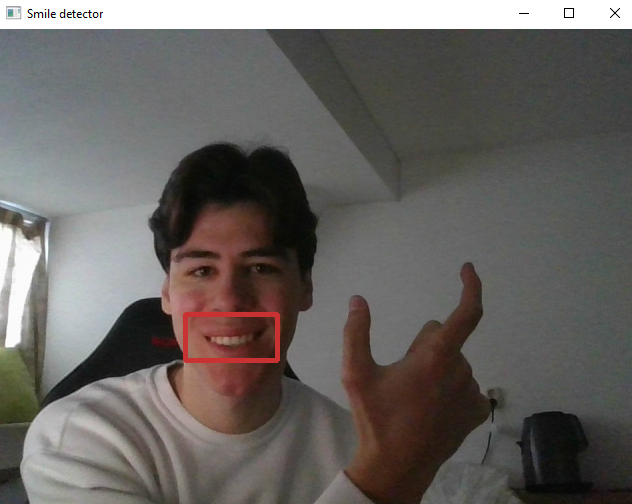


Once this is done, it's important to make the smile detection as a nested loop within the facial detection and to do this, I used the x & y coordinates as well as the width & height dimensions of the rectangles. Searching for the smile will only be inside the detected face's rectangle.


The inner part of the detected facial rectangle frame is a sub-image of the greater frame, which is the webcam capture. Instead of points that depict the rectangle, we need the slice of the real image. The sub multidimensional array can be obtained by "slicing" the image using certain code. However, this slicing method doesn't work without importing the numpy module. 

After rearranging the code a little and adding the functionality of the next step that's mentioned above, the code looks like this:

In [ ]:
import cv2
import numpy as np

# Face classifier
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Smile classifier
smile_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Obtain the webcam feed
webcam = cv2.VideoCapture(0)

# Show the current frame (going frame by frame)
while True:
    # Read only the current frame from the webcam
    # Get the tuple containing a Boolean output for whether it's successfully
    # read and then the actual frame
    successful_frame_read, frame = webcam.read()

    # Abort in case there is an error
    if not successful_frame_read:
        break

    # Convert to grayscale (black & white) because the facial recognition ability
    # is increased since RGB has 3 channels while the grayscale has only 1
    # Also, it is a requirement for opencv.
    frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect the faces & the smiles
    faces = face_detector.detectMultiScale(frame_grayscale)

    # Run the face detection within each of those faces
    # We have the x and y coordinates, the width and the height of the rectangle
    for (x, y, w, h) in faces:

        # Draw a rectangle around the face
        cv2.rectangle(frame, (x,y), (x+w, y+h), (50, 200, 50), 4)
        
        # Slicing the captured webcame frame within the detected face's bounds
        # the_face represents the sub frame - using numpy N-dimensional array slicing
        the_face = frame[y:y+h, x:x+w]

        # Convert the sub frame to grayscale
        face_grayscale = cv2.cvtColor(the_face, cv2.COLOR_BGR2GRAY)

        smiles = smile_detector.detectMultiScale(face_grayscale, scaleFactor=1.6, minNeighbors=20)

        # Creating a smile detection loop nested in detecting the face
        for (x_, y_, w_, h_) in smiles:
            
            # Draw a rectangle around the smile
            cv2.rectangle(the_face, (x_,y_), (x_+w_, y_+h_), (50, 50, 200), 4)
        
    # Show the frame
    cv2.imshow('Smile detector', frame)

    # Keep the window open until a key is pressed
    # Updated every 1ms - close to real time
    cv2.waitKey(1)

# Code executed without any errors
print('Code completed')

# Cleanup
webcam.release()
# cv2.destroyAllWindows()

After running this code the result is the following:

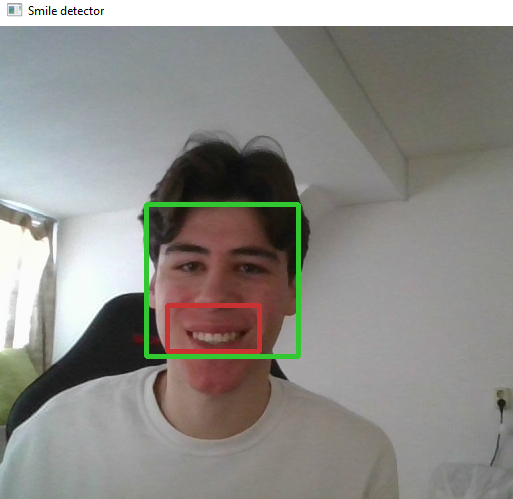

However, since I was using the Haar-cascade algorithm for smile detection I was also using it for facial detection here and a common issue I had before, had appeared again.

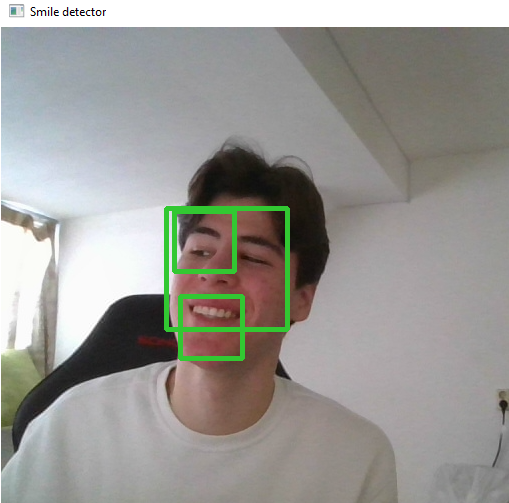

Despite this problem, I decided to add a label on whether someone is smiling (a smile is detected) or not. This is really simple and what the code does is essentially instead of drawing the rectangle around the smile, I add the label using cv2.putText, make the coordinates so it's at the bottom left and make it white colored.

In [ ]:
        # If there is at least one smile, display the text "smiling" instead of drawing a rectangle
        if len(smiles) > 0:
            cv2.putText(frame, 'smiling', (x, y+h+40), fontScale=3, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(255, 255, 255))
        

The following output detecting a smile looks like this now:

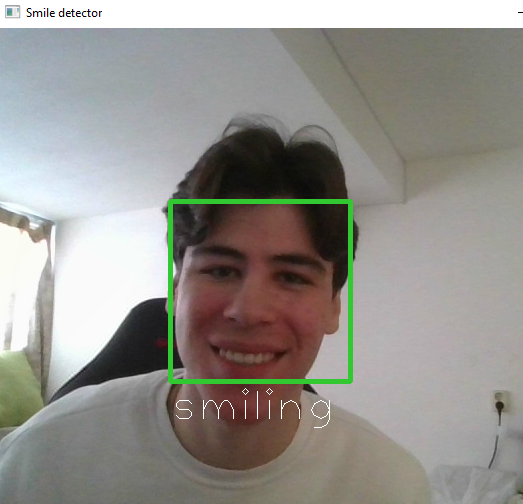


In order to optimize this code, I decided to implement the smile detection using the Haar-cascade algorithm upon the facial detection that uses the MTCNN algorithm.

In [ ]:
import cv2
import numpy as np
from mtcnn import MTCNN

# Face classifier
face_detector = MTCNN()
# Smile classifier
smile_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

# Obtain the webcam feed
webcam = cv2.VideoCapture(0)

# Show the current frame (going frame by frame)
while True:
    # Read only the current frame from the webcam
    # Get the tuple containing a Boolean output for whether it's successfully
    # read and then the actual frame
    successful_frame_read, frame = webcam.read()

    # Abort in case there is an error
    if not successful_frame_read:
        break

    # Convert to grayscale (black & white) because the facial recognition ability
    # is increased since RGB has 3 channels while the grayscale has only 1
    # Also, it is a requirement for opencv.
    frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect the faces & the smiles
    faces = face_detector.detect_faces(frame)

    # Run the face detection within each of those faces
    # We have the x and y coordinates, the width and the height of the rectangle
    for face in faces:
        
        # Draw a rectangle around the face
        x, y, w, h = face['box']
        cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
        
        # Slicing the captured webcame frame within the detected face's bounds
        # the_face represents the sub frame - using numpy N-dimensional array slicing
        the_face = frame[y:y+h, x:x+w]

        # Convert the sub frame to grayscale
        face_grayscale = cv2.cvtColor(the_face, cv2.COLOR_BGR2GRAY)

        smiles = smile_detector.detectMultiScale(face_grayscale, scaleFactor=1.6, minNeighbors=20)

        # Creating a smile detection loop nested in detecting the face
        #for (x_, y_, w_, h_) in smiles:
            
            # Draw a rectangle around the smile
            #cv2.rectangle(the_face, (x_,y_), (x_+w_, y_+h_), (50, 50, 200), 2)

        # If there is at least one smile, display the text "smiling" instead of drawing a rectangle
        if len(smiles) > 0:
            cv2.putText(frame, 'smiling', (x, y+h+40), fontScale=3, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(255, 255, 255))
        
    # Show the frame
    cv2.imshow('Smile detector', frame)

    # Keep the window open until a key is pressed
    # Updated every 1ms - close to real time
    cv2.waitKey(1)

# Code executed without any errors
print('Code completed')

# Cleanup
webcam.release()
# cv2.destroyAllWindows()

The following screenshot is the smiling variation on the MTCNN algorithm. The big issue with this algorithm is the runtime since in real time this program runs very slowly and definitely needs a boost in operation time. The runtime is displayed and the image frame is captured once every 20ms +/-

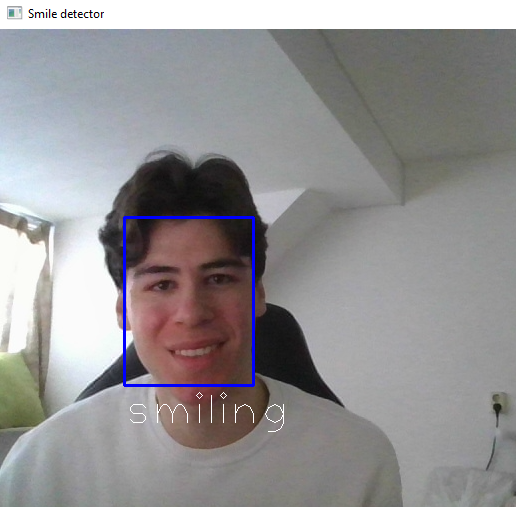  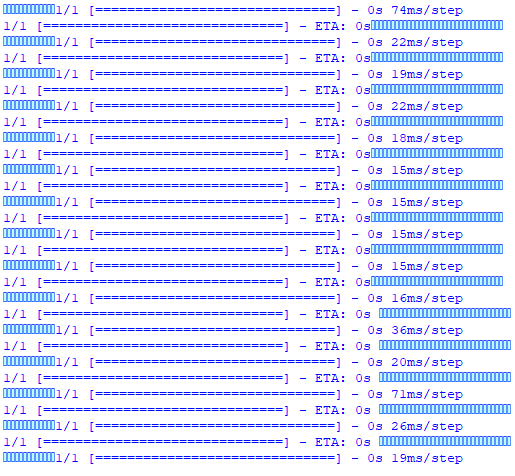


Once I changed my graphics card settings so python.exe is executed prioritizing my graphics card and within the task manager I set the priority to high, the program worked a little better but nothing really noticable by human eye

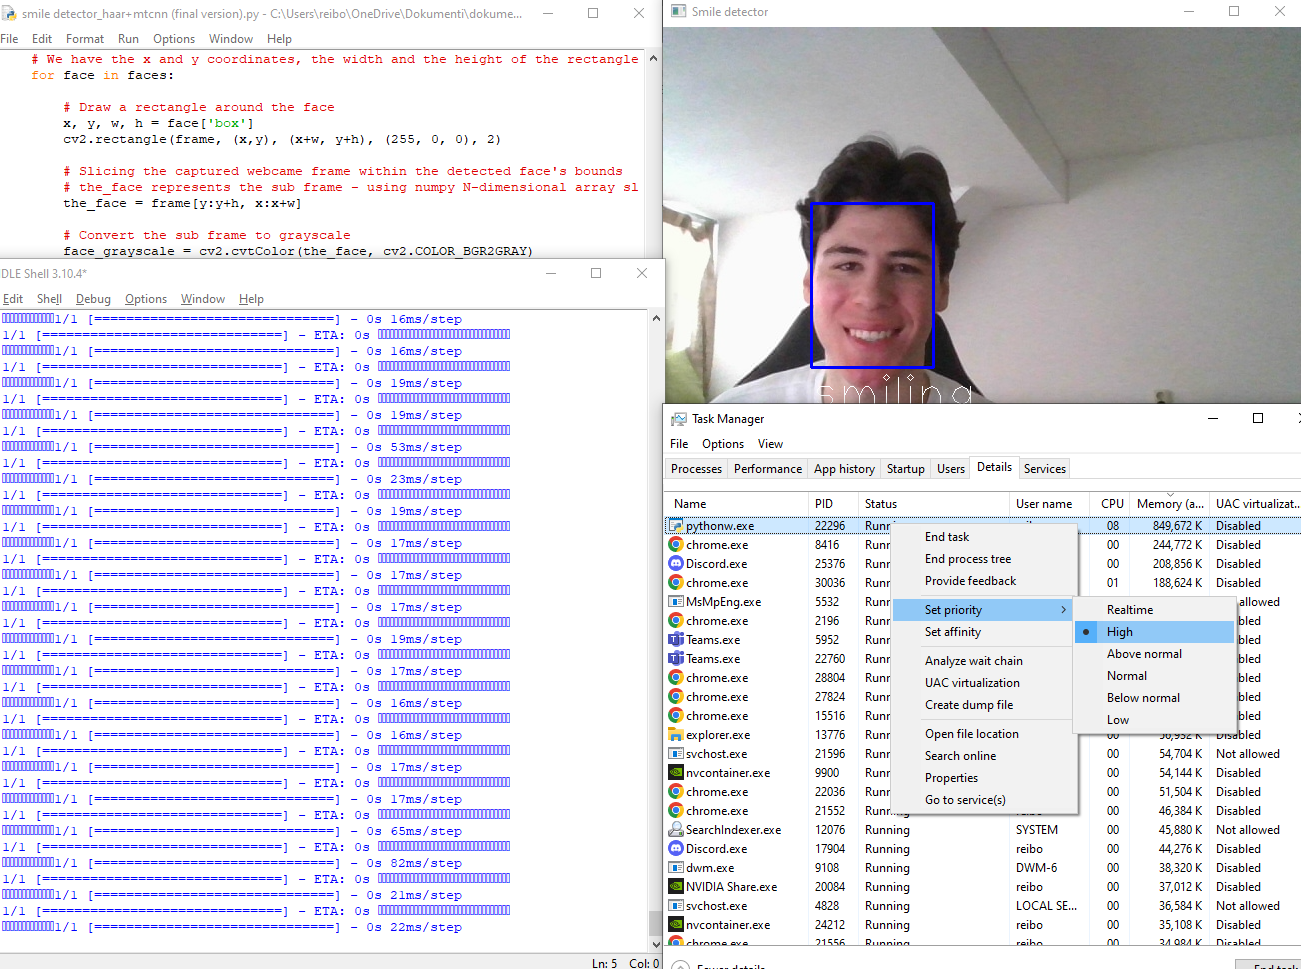

Even after removing all the comments and optimizing the code for better runtime I couldn't get the webcam capture to 1ms or even close to it (the minimal it would go to is 12ms).
So, I decided to try using the HOG algorithm just in case I am able to perform faster webcam capture since it may be a bit less accurate it should run faster.

With the code below, the program ran much faster and closer to real-time and the accuracy seems much greater than the Haar-cascade. Thus, I decided this meets my goal set for the semester.

In [ ]:
import cv2
import numpy as np
import dlib

face_detector = dlib.get_frontal_face_detector()
smile_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')

webcam = cv2.VideoCapture(0)

while True:
    successful_frame_read, frame = webcam.read()
    if not successful_frame_read:
        break

    frame_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(frame, 0)

    for (i, rect) in enumerate(faces):
        x, y = rect.left(), rect.top()
        w, h = rect.right()-x, rect.bottom()-y
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)
        
        the_face = frame[y:y+h, x:x+w]
        face_grayscale = cv2.cvtColor(the_face, cv2.COLOR_BGR2GRAY)

        smiles = smile_detector.detectMultiScale(face_grayscale, scaleFactor=1.6, minNeighbors=20)

        if len(smiles) > 0:
            cv2.putText(frame, 'smiling', (x, y+h+40), fontScale=3, fontFace=cv2.FONT_HERSHEY_PLAIN, color=(255, 255, 255))
        
    cv2.imshow('Smile detector', frame)
    cv2.waitKey(1)

webcam.release()


The code works almost perfectly with one small issue - on my face it rarely labels me smiling unless I have open mouth - show my teeth.

The gif of the video file that shows the program working can be found below: (in case it doesn't work  for you, try opening the file from the actual folder containing all programs)

In [ ]:
import ipywidgets as widgets
display(widgets.HTML(f'<img src="{IMG_0715.gif}" width="750" align="center">'))

In order to test whether it worked on multiple people I showed a random image of Loki smiling to the webcam and the code works very well - the farther the image, the worse it works.

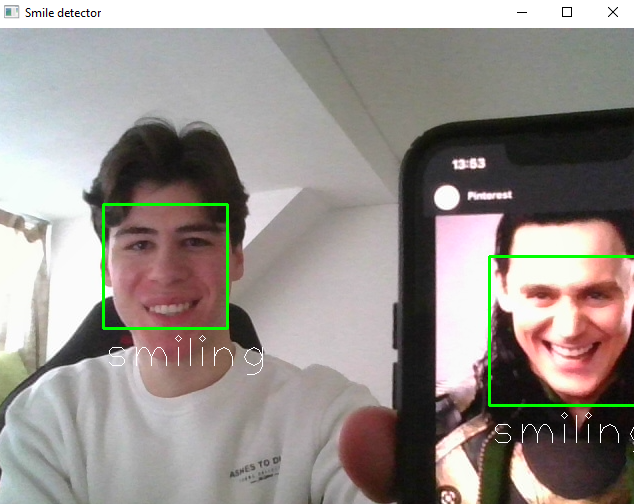